Running Enhanced Natural Gas Trading Strategy

=== Enhanced Strategy ===
Loaded price data with 1621 rows
Loaded inventory data with 6708 rows
Loaded HDD data with 2350 rows
Loaded CDD data with 2350 rows
Loaded positioning data with 334 rows
Created merged dataset with 1621 rows
Added trading features to dataset
Added enhanced trading features to dataset
Enhanced Backtest Results:
Total Trades: 9
Win Rate: 44.44%
Total Return: -1.76%
Annual Return: -0.27%
Avg Return per Trade: -0.20%
Max Drawdown: 2.48%
Sharpe Ratio: -2.64


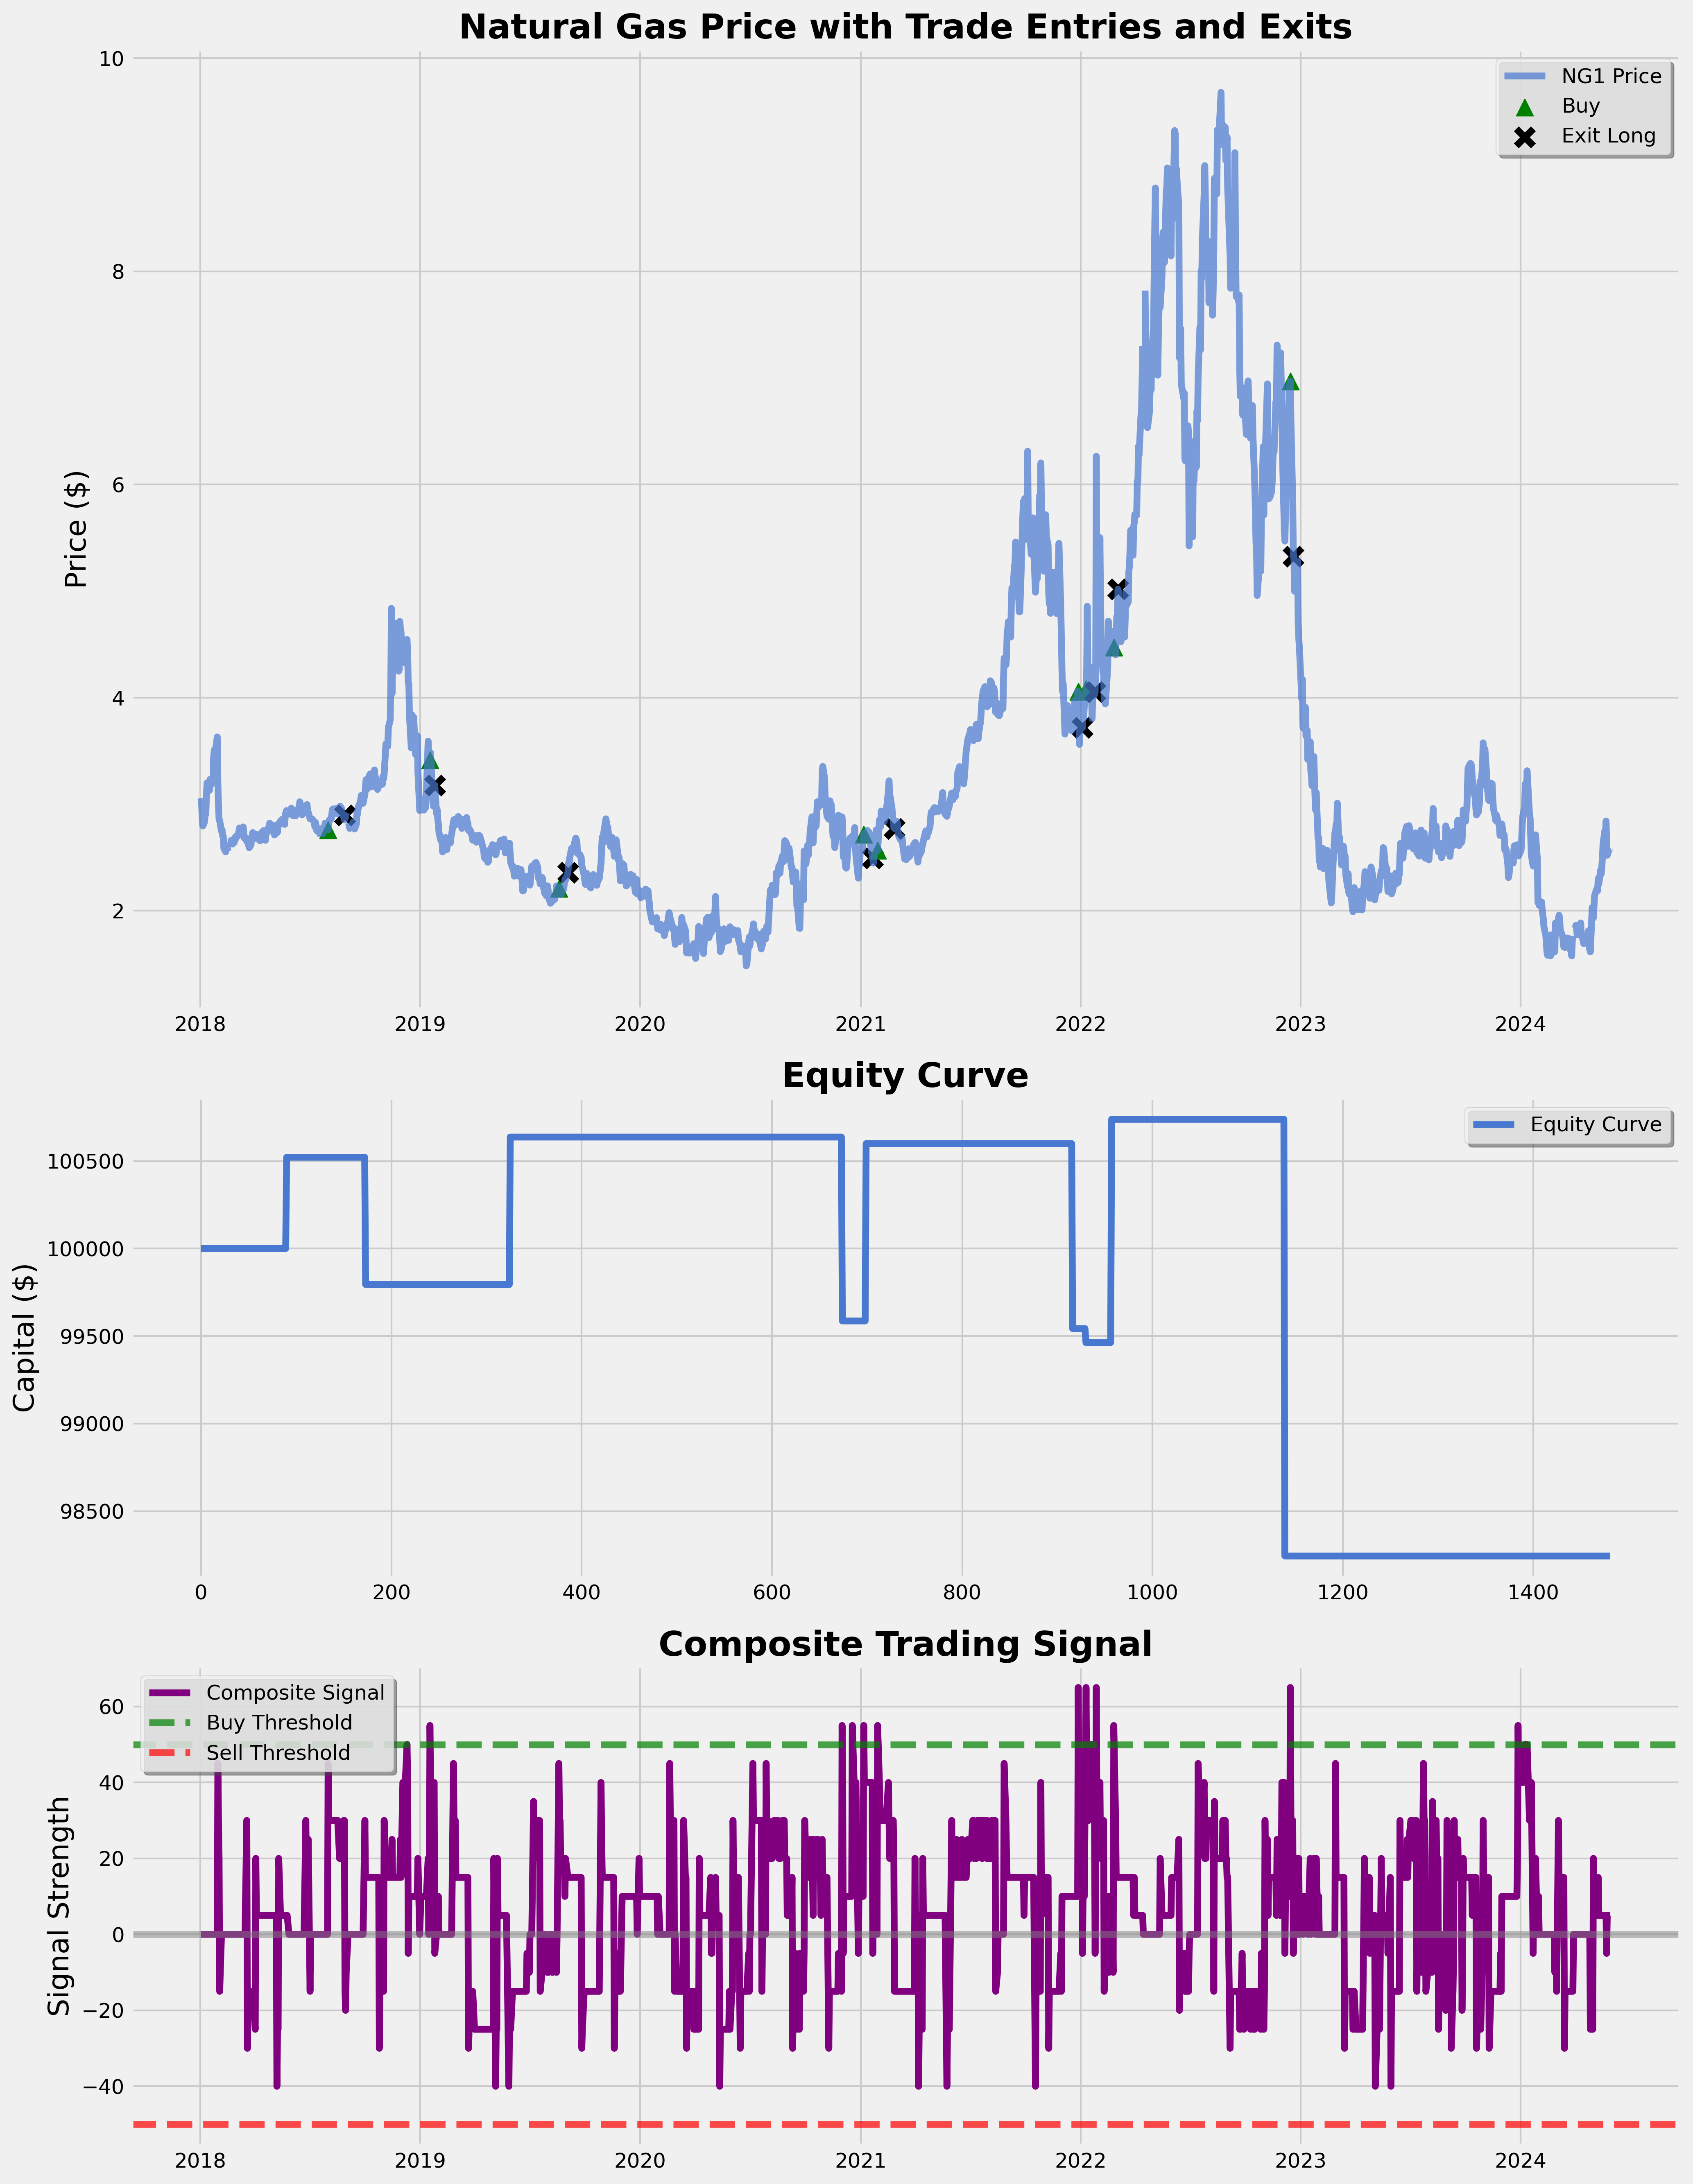

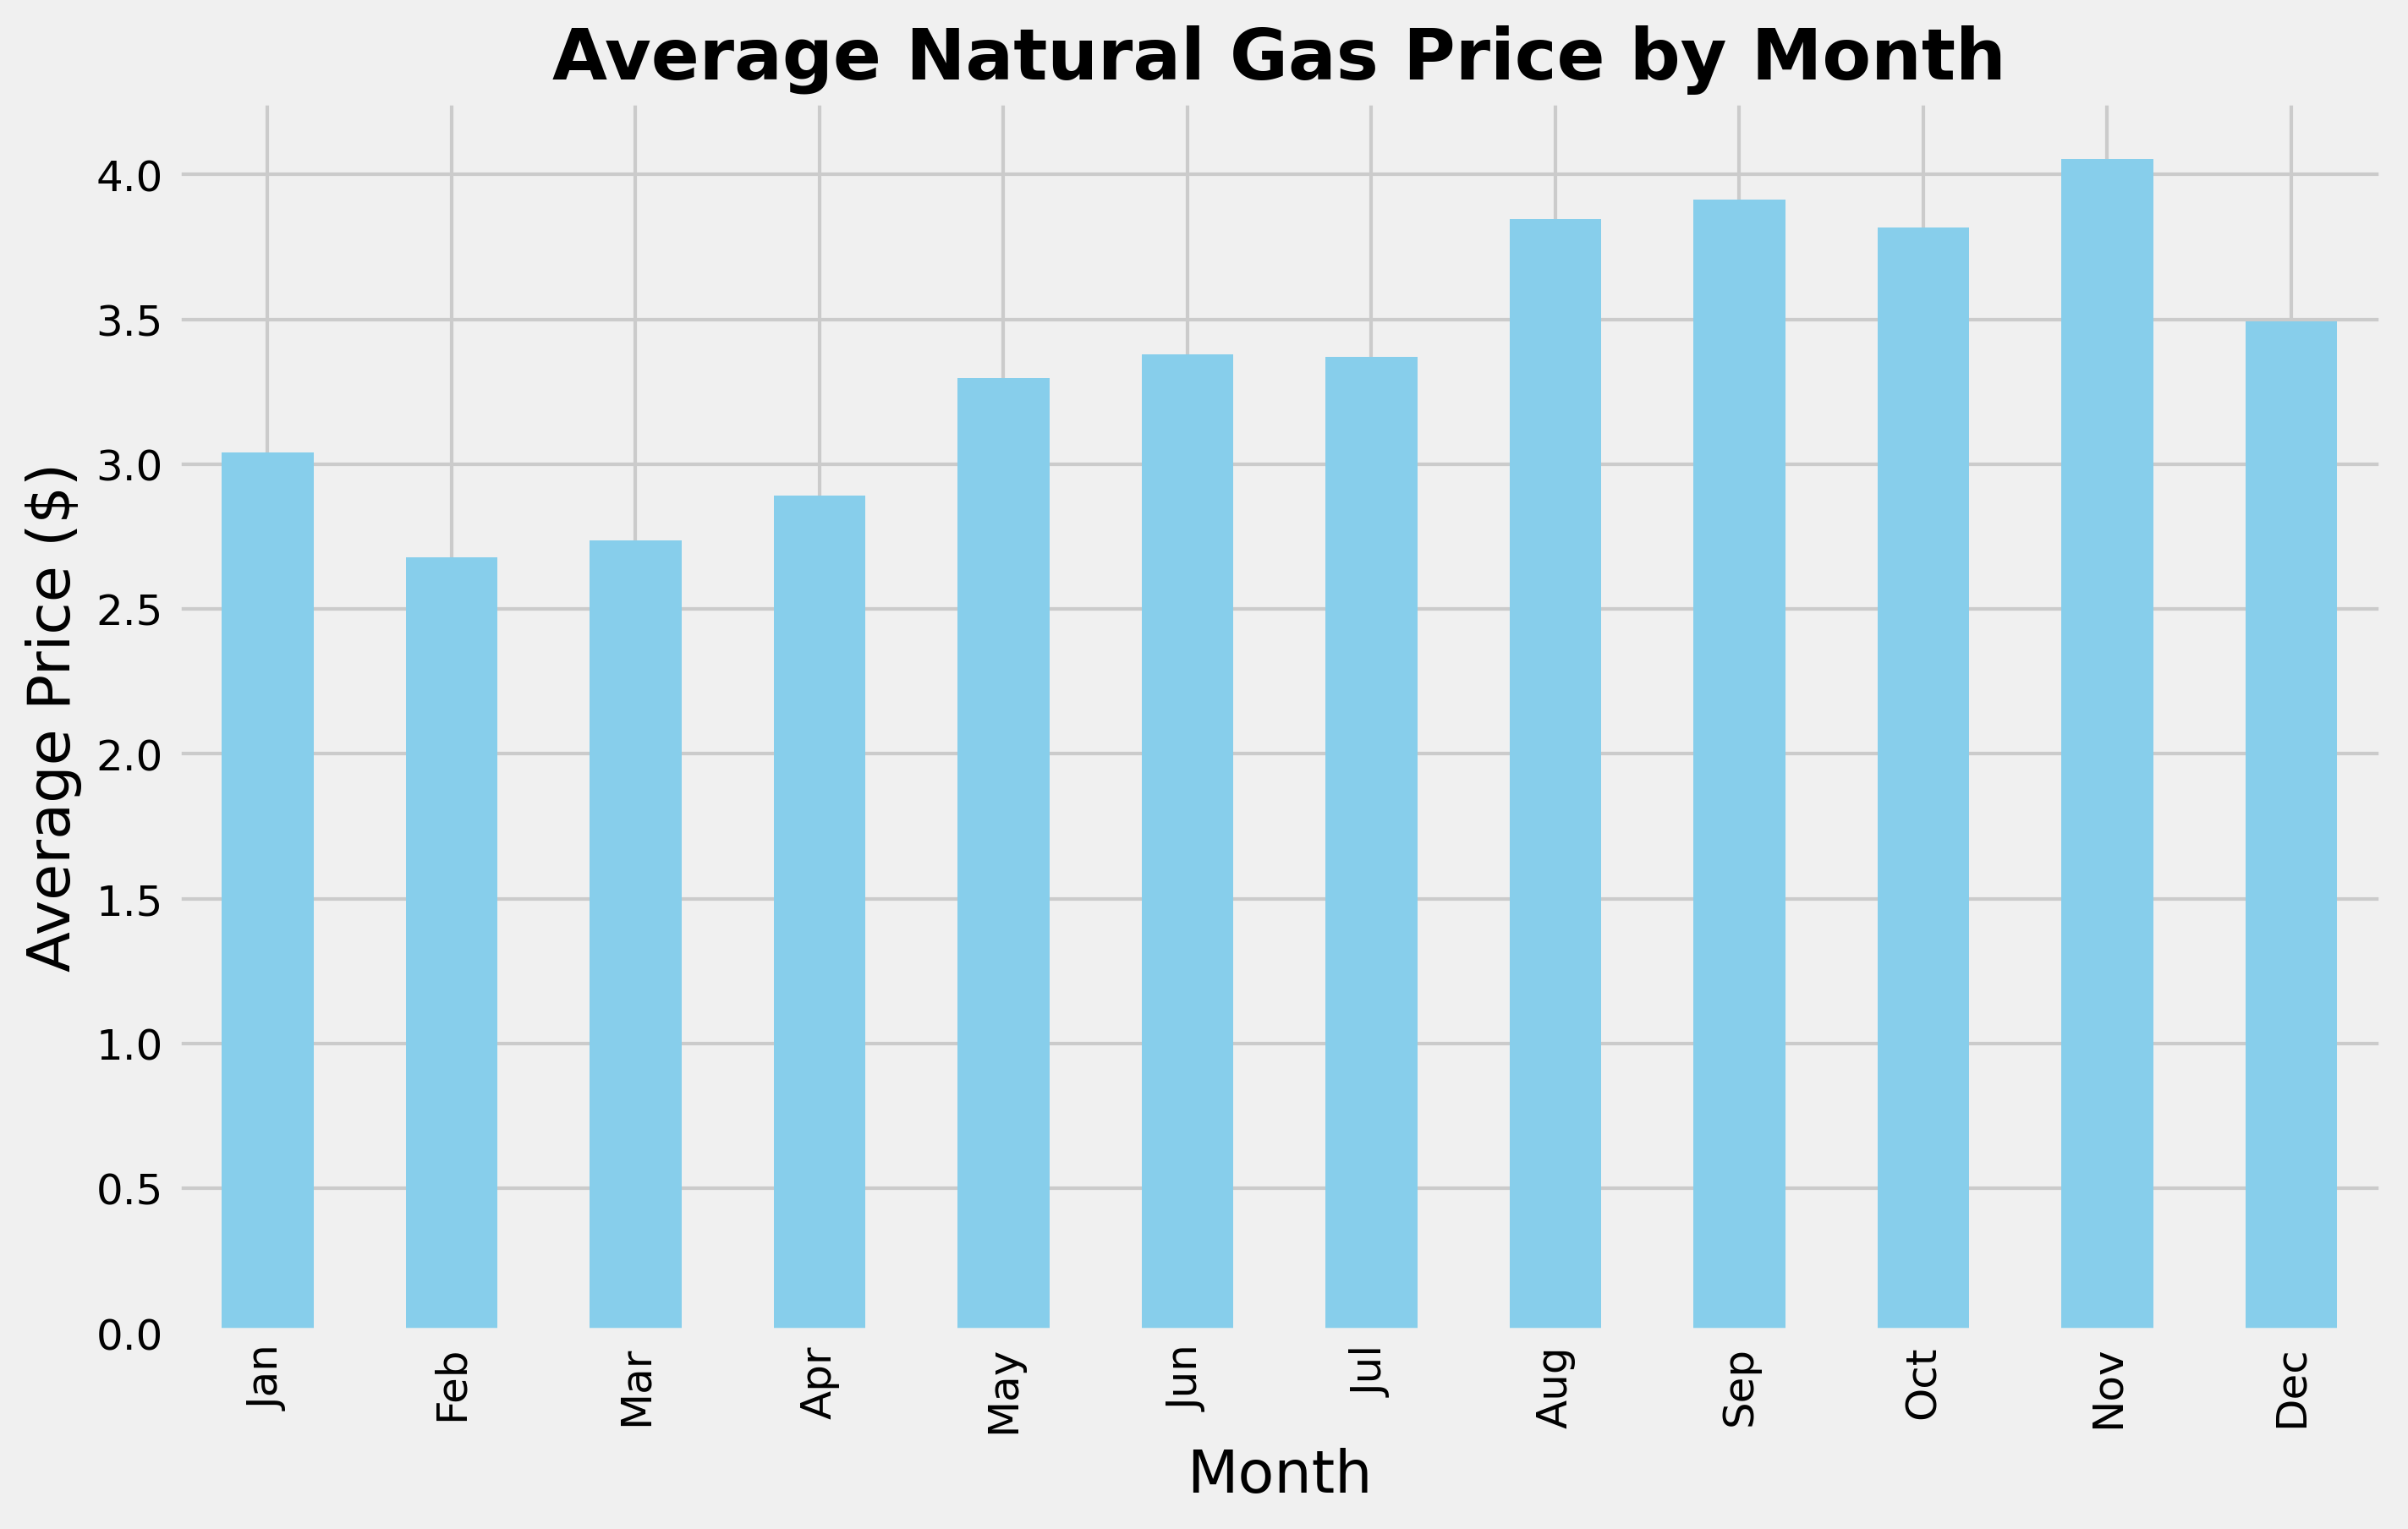

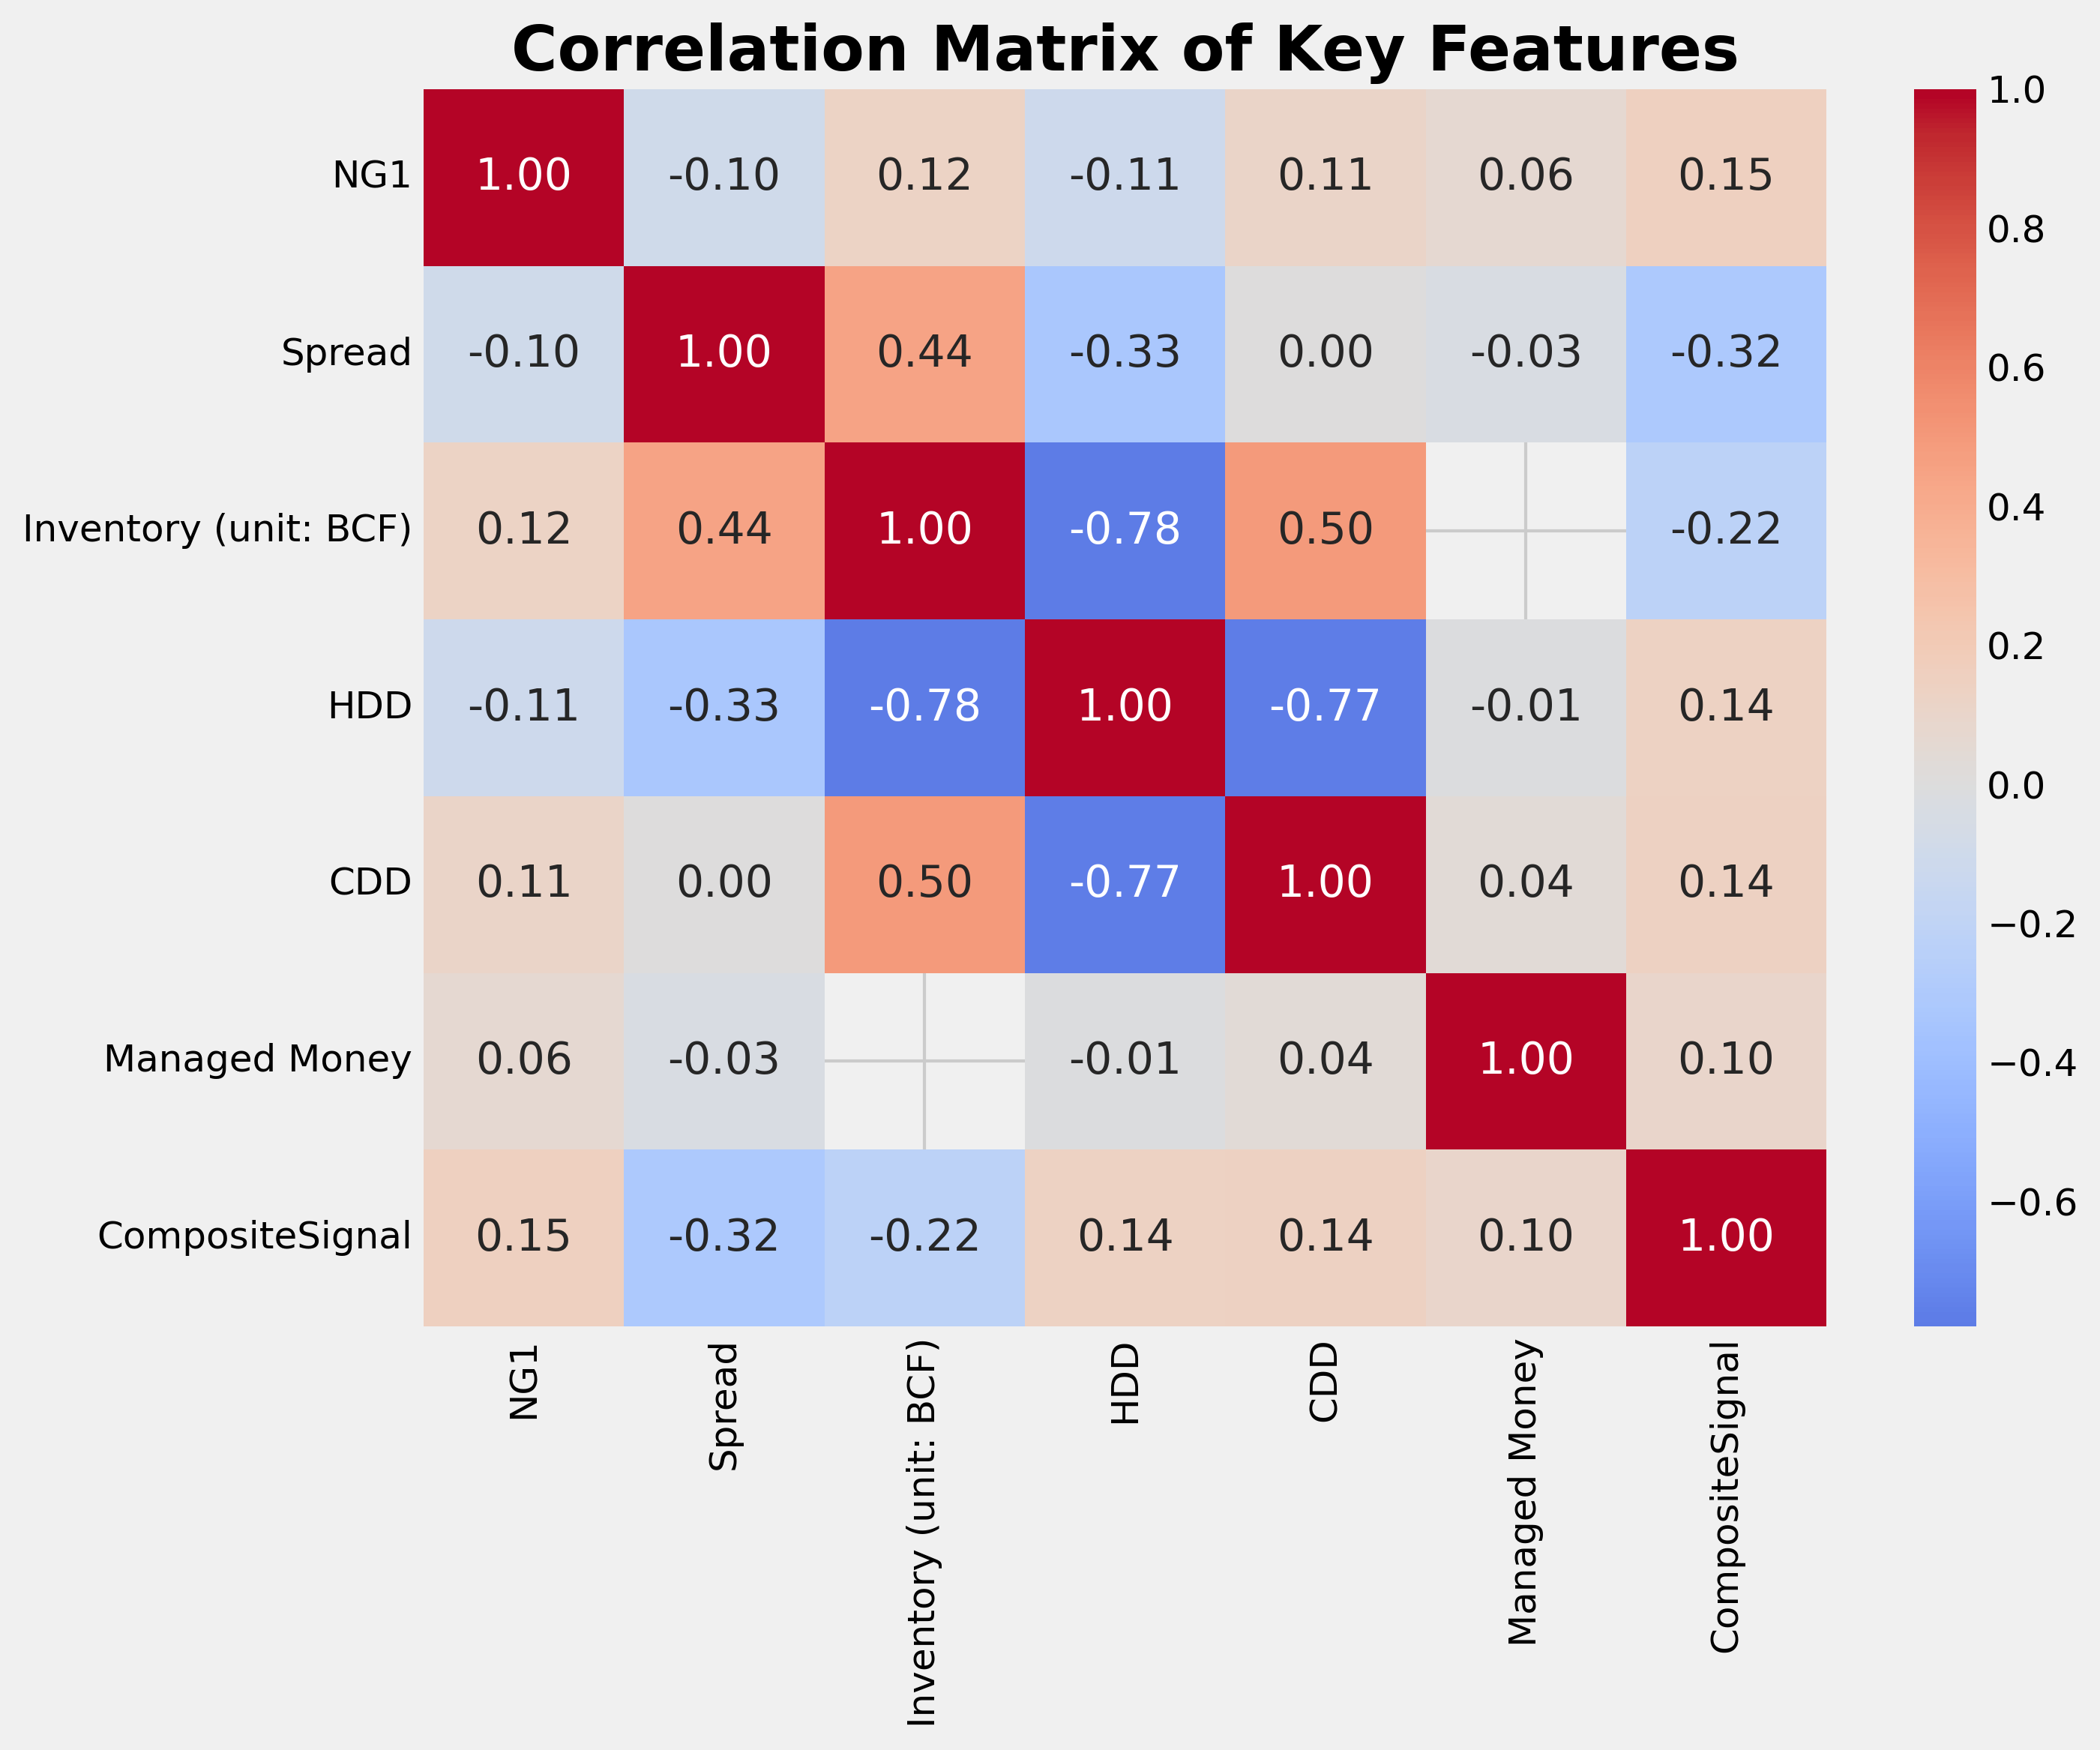


=== Enhanced Strategy Results ===
Total Return: -1.76%
Annual Return: -0.27%
Win Rate: 44.44%
Max Drawdown: 2.48%
Sharpe Ratio: -2.64


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('muted')
pd.set_option('display.max_columns', None)

class NaturalGasStrategy:
    def __init__(self):
        """Initialize the Natural Gas Trading Strategy class"""
        self.price_data = None
        self.inventory_data = None
        self.hdd_data = None
        self.cdd_data = None
        self.positioning_data = None
        self.merged_data = None
        self.trading_data = None
        self.trades = []
        self.performance = {}
    
    def load_data(self, price_file, inventory_file, hdd_file, cdd_file, positioning_file):
        """
        Load all required datasets
        
        Parameters:
        -----------
        price_file: str - Path to price data CSV
        inventory_file: str - Path to inventory data CSV
        hdd_file: str - Path to heating degree days CSV
        cdd_file: str - Path to cooling degree days CSV
        positioning_file: str - Path to market positioning CSV
        """
        # Load price data
        self.price_data = pd.read_csv(price_file)
        print(f"Loaded price data with {len(self.price_data)} rows")
        
        # Load inventory data
        self.inventory_data = pd.read_csv(inventory_file)
        print(f"Loaded inventory data with {len(self.inventory_data)} rows")
        
        # Load weather data
        self.hdd_data = pd.read_csv(hdd_file)
        print(f"Loaded HDD data with {len(self.hdd_data)} rows")
        
        self.cdd_data = pd.read_csv(cdd_file)
        print(f"Loaded CDD data with {len(self.cdd_data)} rows")
        
        # Load positioning data
        self.positioning_data = pd.read_csv(positioning_file)
        print(f"Loaded positioning data with {len(self.positioning_data)} rows")
        
        # Preprocess all datasets
        self._preprocess_data()
    
    def _preprocess_data(self):
        """Preprocess and standardize all datasets"""
        # Standardize date format across all datasets
        self.price_data['StandardDate'] = self.price_data['Date'].apply(self._standardize_date)
        self.inventory_data['StandardDate'] = self.inventory_data['Date'].apply(self._standardize_date)
        self.hdd_data['StandardDate'] = self.hdd_data['Date'].apply(self._standardize_date)
        self.cdd_data['StandardDate'] = self.cdd_data['Date'].apply(self._standardize_date)
        self.positioning_data['StandardDate'] = self.positioning_data['Date'].apply(self._standardize_date)
        
        # Convert dates to datetime
        self.price_data['StandardDate'] = pd.to_datetime(self.price_data['StandardDate'])
        self.inventory_data['StandardDate'] = pd.to_datetime(self.inventory_data['StandardDate'])
        self.hdd_data['StandardDate'] = pd.to_datetime(self.hdd_data['StandardDate'])
        self.cdd_data['StandardDate'] = pd.to_datetime(self.cdd_data['StandardDate'])
        self.positioning_data['StandardDate'] = pd.to_datetime(self.positioning_data['StandardDate'])
        
        # Sort all datasets by date
        self.price_data.sort_values('StandardDate', inplace=True)
        self.inventory_data.sort_values('StandardDate', inplace=True)
        self.hdd_data.sort_values('StandardDate', inplace=True)
        self.cdd_data.sort_values('StandardDate', inplace=True)
        self.positioning_data.sort_values('StandardDate', inplace=True)
    
    def _standardize_date(self, date_str):
        """
        Convert date strings to standard format (YYYY-MM-DD)
        
        Parameters:
        -----------
        date_str: str - Date string to standardize
        
        Returns:
        --------
        str - Standardized date string
        """
        if not date_str or not isinstance(date_str, str):
            return None
        
        parts = date_str.split('-')
        if len(parts) != 3:
            return date_str
        
        # Check if DD-MM-YYYY format
        if len(parts[0]) == 2 and len(parts[1]) == 2 and len(parts[2]) == 4:
            return f"{parts[2]}-{parts[1]}-{parts[0]}"
        # Already in YYYY-MM-DD format
        elif len(parts[0]) == 4 and len(parts[1]) == 2 and len(parts[2]) == 2:
            return date_str
        else:
            return date_str  # Return as is if format is unrecognized
    
    def merge_datasets(self):
        """Merge all datasets on StandardDate"""
        # Start with price data as the base
        merged = self.price_data[['StandardDate', 'Date', 'NG1', 'NG2']].copy()
        merged.rename(columns={'Date': 'OriginalDate'}, inplace=True)
        
        # Add inventory data
        inventory_subset = self.inventory_data[['StandardDate', 'Inventory (unit: BCF)']].copy()
        merged = pd.merge(merged, inventory_subset, on='StandardDate', how='left')
        
        # Add HDD data
        hdd_subset = self.hdd_data[['StandardDate', 'HDD']].copy()
        merged = pd.merge(merged, hdd_subset, on='StandardDate', how='left')
        
        # Add CDD data
        cdd_subset = self.cdd_data[['StandardDate', 'CDD']].copy()
        merged = pd.merge(merged, cdd_subset, on='StandardDate', how='left')
        
        # Add positioning data
        positioning_subset = self.positioning_data[['StandardDate', 'Managed Money', 'Producers', 'Swaps']].copy()
        merged = pd.merge(merged, positioning_subset, on='StandardDate', how='left')
        
        # Calculate spread
        merged['Spread'] = merged['NG2'] - merged['NG1']
        
        # Store the merged dataset
        self.merged_data = merged
        print(f"Created merged dataset with {len(merged)} rows")
        
        return merged
    
    def engineer_features(self):
        """Engineer features for the trading strategy"""
        if self.merged_data is None:
            print("Error: No merged data available. Run merge_datasets first.")
            return None
        
        # Create a copy of the merged data for feature engineering
        data = self.merged_data.copy()
        
        # 1. Price and Spread Features
        
        # Calculate price changes
        data['PriceChange'] = data['NG1'].diff()
        data['PriceChangePct'] = data['NG1'].pct_change() * 100
        
        # Calculate spread changes
        data['SpreadChange'] = data['Spread'].diff()
        data['SpreadChangePct'] = data['Spread'].pct_change() * 100
        
        # Moving averages for price
        data['MA5'] = data['NG1'].rolling(window=5).mean()
        data['MA20'] = data['NG1'].rolling(window=20).mean()
        
        # MA crossover signal
        data['MA5_GT_MA20'] = (data['MA5'] > data['MA20']).astype(int)
        data['MACrossSignal'] = data['MA5_GT_MA20'].diff()
        
        # 2. Inventory Features
        
        # Inventory changes
        data['InventoryChange'] = data['Inventory (unit: BCF)'].diff()
        data['InventoryChangePct'] = data['Inventory (unit: BCF)'].pct_change() * 100
        
        # 3. Weather Features
        
        # Total degree days
        data['TotalDegreeDays'] = data['HDD'] + data['CDD']
        
        # Weather-adjusted inventory
        data['WeatherAdjustedInventory'] = data.apply(
            lambda x: x['Inventory (unit: BCF)'] / x['TotalDegreeDays'] if x['TotalDegreeDays'] > 0 else x['Inventory (unit: BCF)'], 
            axis=1
        )
        
        # 4. Positioning Features
        
        # Managed Money position changes
        data['ManagedMoneyChange'] = data['Managed Money'].diff()
        data['ManagedMoneyChangePct'] = data['Managed Money'].pct_change() * 100
        
        # Managed Money to price ratio
        data['MMPriceRatio'] = data['Managed Money'] / data['NG1']
        
        # 5. Seasonality Features
        
        # Extract month and season
        data['Month'] = data['StandardDate'].dt.month
        data['DayOfWeek'] = data['StandardDate'].dt.dayofweek
        
        # Season flags
        data['IsWinter'] = data['Month'].isin([12, 1, 2]).astype(int)
        data['IsSummer'] = data['Month'].isin([6, 7, 8]).astype(int)
        data['IsShoulder'] = (~data['Month'].isin([12, 1, 2, 6, 7, 8])).astype(int)
        
        # 6. Composite Trading Signals
        
        # Initialize composite signal
        data['CompositeSignal'] = 0
        
        # Calculate composite signal components only where we have sufficient data
        mask = (data['MA5'].notna() & data['MA20'].notna())
        
        # For rows with sufficient data, calculate the signal
        for idx in data[mask].index:
            signal = 0
            
            # Technical component (40% weight)
            # MA crossover signal
            if data.loc[idx, 'MACrossSignal'] == 1:
                signal += 30  # Bullish crossover
            elif data.loc[idx, 'MACrossSignal'] == -1:
                signal -= 30  # Bearish crossover
            elif data.loc[idx, 'MA5_GT_MA20'] == 1:
                signal += 15  # MA5 > MA20 (uptrend)
            else:
                signal -= 15  # MA5 < MA20 (downtrend)
            
            # Spread dynamics
            if not np.isnan(data.loc[idx, 'SpreadChange']):
                if data.loc[idx, 'SpreadChange'] < -0.05:
                    signal += 10  # Narrowing spread (can be bullish)
                elif data.loc[idx, 'SpreadChange'] > 0.05:
                    signal -= 10  # Widening spread (can be bearish)
            
            # Fundamental component (30% weight)
            # Inventory changes
            if not np.isnan(data.loc[idx, 'InventoryChange']):
                if data.loc[idx, 'InventoryChange'] < -10:
                    signal += 20  # Large inventory decrease (bullish)
                elif data.loc[idx, 'InventoryChange'] < -5:
                    signal += 10  # Moderate inventory decrease (somewhat bullish)
                elif data.loc[idx, 'InventoryChange'] > 10:
                    signal -= 20  # Large inventory increase (bearish)
                elif data.loc[idx, 'InventoryChange'] > 5:
                    signal -= 10  # Moderate inventory increase (somewhat bearish)
            
            # Weather metrics
            if not np.isnan(data.loc[idx, 'HDD']):
                if data.loc[idx, 'HDD'] > 10 and data.loc[idx, 'IsWinter'] == 1:
                    signal += 15  # Cold winter weather (bullish)
            
            if not np.isnan(data.loc[idx, 'CDD']):
                if data.loc[idx, 'CDD'] > 10 and data.loc[idx, 'IsSummer'] == 1:
                    signal += 10  # Hot summer weather (bullish)
            
            # Positioning component (20% weight)
            if not np.isnan(data.loc[idx, 'ManagedMoneyChange']):
                if data.loc[idx, 'ManagedMoneyChange'] > 10000:
                    signal += 15  # Strong money manager buying (bullish)
                elif data.loc[idx, 'ManagedMoneyChange'] > 5000:
                    signal += 7  # Moderate money manager buying (somewhat bullish)
                elif data.loc[idx, 'ManagedMoneyChange'] < -10000:
                    signal -= 15  # Strong money manager selling (bearish)
                elif data.loc[idx, 'ManagedMoneyChange'] < -5000:
                    signal -= 7  # Moderate money manager selling (somewhat bearish)
            
            # Seasonal component (10% weight)
            if data.loc[idx, 'Month'] in [1, 12]:
                signal += 10  # Peak winter months (bullish)
            elif data.loc[idx, 'Month'] in [7, 8]:
                signal += 5  # Peak summer months (somewhat bullish)
            elif data.loc[idx, 'Month'] in [4, 5]:
                signal -= 10  # Shoulder months (bearish)
            
            # Store the composite signal
            data.loc[idx, 'CompositeSignal'] = signal
        
        # Store the enhanced data
        self.trading_data = data
        print(f"Added trading features to dataset")
        
        return data
    
    def visualize_results(self):
        """Visualize the backtest results"""
        if not self.trades or not self.performance:
            print("Error: No backtest results available. Run backtest_strategy first.")
            return
        
        # Convert trades to DataFrame
        trades_df = pd.DataFrame(self.trades)
        
        # Create a figure with subplots
        fig, axs = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [2, 1, 1]})
        
        # Plot 1: Price and Trades
        if 'StandardDate' in self.trading_data.columns and 'NG1' in self.trading_data.columns:
            axs[0].plot(self.trading_data['StandardDate'], self.trading_data['NG1'], label='NG1 Price', alpha=0.7)
            
            # Plot entry and exit points
            for i, trade in enumerate(self.trades):
                if trade['Type'] == 'Entry':
                    if trade['Direction'] == 'Long':
                        axs[0].scatter(trade['Date'], trade['Price'], color='green', marker='^', s=100, label='Buy' if i==0 else "")
                    else:
                        axs[0].scatter(trade['Date'], trade['Price'], color='red', marker='v', s=100, label='Sell' if i==0 else "")
                elif trade['Type'] == 'Exit':
                    if trade['Direction'] == 'Long':
                        axs[0].scatter(trade['Date'], trade['Price'], color='black', marker='x', s=100, label='Exit Long' if i==1 else "")
                    else:
                        axs[0].scatter(trade['Date'], trade['Price'], color='black', marker='x', s=100, label='Exit Short' if i==2 else "")
            
            axs[0].set_title('Natural Gas Price with Trade Entries and Exits')
            axs[0].set_ylabel('Price ($)')
            axs[0].legend(loc='best')
            axs[0].grid(True)
        
        # Plot 2: Equity Curve
        axs[1].plot(self.performance['equity_curve'], label='Equity Curve')
        axs[1].set_title('Equity Curve')
        axs[1].set_ylabel('Capital ($)')
        axs[1].legend(loc='best')
        axs[1].grid(True)
        
        # Plot 3: Composite Signal
        if 'StandardDate' in self.trading_data.columns and 'CompositeSignal' in self.trading_data.columns:
            axs[2].plot(self.trading_data['StandardDate'], self.trading_data['CompositeSignal'], label='Composite Signal', color='purple')
            
            # Add horizontal lines for signal thresholds
            axs[2].axhline(y=50, color='green', linestyle='--', alpha=0.7, label='Buy Threshold')
            axs[2].axhline(y=-50, color='red', linestyle='--', alpha=0.7, label='Sell Threshold')
            axs[2].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            
            axs[2].set_title('Composite Trading Signal')
            axs[2].set_ylabel('Signal Strength')
            axs[2].legend(loc='best')
            axs[2].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Monthly seasonality
        if 'Month' in self.trading_data.columns and 'NG1' in self.trading_data.columns:
            monthly_avg = self.trading_data.groupby('Month')['NG1'].mean()
            
            plt.figure(figsize=(10, 6))
            monthly_avg.plot(kind='bar', color='skyblue')
            plt.title('Average Natural Gas Price by Month')
            plt.xlabel('Month')
            plt.ylabel('Average Price ($)')
            plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.grid(True, axis='y')
            plt.show()
        
        # Correlation matrix of key features
        if self.trading_data is not None:
            features = ['NG1', 'Spread', 'Inventory (unit: BCF)', 'HDD', 'CDD', 'Managed Money', 'CompositeSignal']
            features = [f for f in features if f in self.trading_data.columns]
            
            if features:
                correlation_matrix = self.trading_data[features].corr()
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
                plt.title('Correlation Matrix of Key Features')
                plt.tight_layout()
                plt.show()

# Advanced trading strategy implementation
class EnhancedNaturalGasStrategy(NaturalGasStrategy):
    """Enhanced version of the Natural Gas Trading Strategy with more sophisticated features"""
    
    def engineer_features(self):
        """Engineer additional advanced features for the enhanced strategy"""
        # Get basic features from parent class
        data = super().engineer_features()
        
        # Add volatility-based features
        data['Volatility'] = data['NG1'].rolling(window=20).std()
        data['VolatilityRatio'] = data['Volatility'] / data['Volatility'].rolling(window=60).mean()
        
        # Add RSI (Relative Strength Index)
        def calculate_rsi(prices, period=14):
            delta = prices.diff()
            gain = delta.where(delta > 0, 0).rolling(window=period).mean()
            loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))
        
        data['RSI'] = calculate_rsi(data['NG1'])
        
        # Add Bollinger Bands
        data['BollingerMiddle'] = data['NG1'].rolling(window=20).mean()
        data['BollingerStd'] = data['NG1'].rolling(window=20).std()
        data['UpperBand'] = data['BollingerMiddle'] + (data['BollingerStd'] * 2)
        data['LowerBand'] = data['BollingerMiddle'] - (data['BollingerStd'] * 2)
        data['BollingerPosition'] = (data['NG1'] - data['LowerBand']) / (data['UpperBand'] - data['LowerBand'])
        
        # Add momentum features
        data['Momentum5d'] = data['NG1'] / data['NG1'].shift(5) - 1
        data['Momentum20d'] = data['NG1'] / data['NG1'].shift(20) - 1
        
        # Spread momentum
        data['SpreadMomentum5d'] = data['Spread'] / data['Spread'].shift(5) - 1
        
        # Enhanced seasonality: historical price performance by month
        monthly_performance = {}
        for month in range(1, 13):
            monthly_data = data[data['Month'] == month]['PriceChangePct'].dropna()
            monthly_performance[month] = monthly_data.mean() if len(monthly_data) > 0 else 0
        
        data['HistoricalMonthPerformance'] = data['Month'].map(monthly_performance)
        
        # Enhanced composite signal calculation
        # Recalculate for rows with sufficient data
        mask = (data['MA5'].notna() & data['MA20'].notna() & data['RSI'].notna())
        
        for idx in data[mask].index:
            # Get the base signal from parent class
            base_signal = data.loc[idx, 'CompositeSignal']
            
            # Add RSI component
            rsi = data.loc[idx, 'RSI']
            if not np.isnan(rsi):
                if rsi < 30:
                    base_signal += 15  # Oversold (bullish)
                elif rsi > 70:
                    base_signal -= 15  # Overbought (bearish)
            
            # Add Bollinger Band component
            bb_position = data.loc[idx, 'BollingerPosition']
            if not np.isnan(bb_position):
                if bb_position < 0.2:
                    base_signal += 10  # Near lower band (potential bullish)
                elif bb_position > 0.8:
                    base_signal -= 10  # Near upper band (potential bearish)
            
            # Add volatility adjustment
            vol_ratio = data.loc[idx, 'VolatilityRatio']
            if not np.isnan(vol_ratio):
                # Reduce signal strength in high volatility environments
                if vol_ratio > 1.2:
                    base_signal *= 0.8
            
            # Add seasonal momentum
            month_perf = data.loc[idx, 'HistoricalMonthPerformance']
            if not np.isnan(month_perf):
                if month_perf > 0.5:
                    base_signal += 10  # Historically strong month
                elif month_perf < -0.5:
                    base_signal -= 10  # Historically weak month
            
            # Store the enhanced composite signal
            data.loc[idx, 'EnhancedSignal'] = base_signal
        
        # Store the enhanced data
        self.trading_data = data
        print(f"Added enhanced trading features to dataset")
        
        return data
    
    def backtest_strategy(self, initial_capital=100000, position_size_pct=0.1, use_enhanced_signal=True):
        """
        Backtest the enhanced trading strategy with dynamic position sizing
        
        Parameters:
        -----------
        initial_capital: float - Starting capital for the backtest
        position_size_pct: float - Base percentage of capital to use per trade
        use_enhanced_signal: bool - Whether to use the enhanced signal or basic signal
        
        Returns:
        --------
        dict - Performance metrics of the strategy
        """
        if self.trading_data is None:
            print("Error: No trading data available. Run engineer_features first.")
            return None
        
        # Create a copy of the trading data for backtesting
        data = self.trading_data.copy()
        
        # Select which signal to use
        signal_column = 'EnhancedSignal' if use_enhanced_signal and 'EnhancedSignal' in data.columns else 'CompositeSignal'
        
        # Initialize tracking variables
        capital = initial_capital
        position = 0  # 0: no position, 1: long, -1: short
        entry_price = 0
        entry_date = None
        trade_history = []
        equity_curve = [initial_capital]
        
        # Additional tracking for analytics
        trades = 0
        wins = 0
        losses = 0
        
        # Skip first 20 rows to ensure we have all technical indicators
        for i in range(20, len(data)):
            row = data.iloc[i]
            current_date = row['StandardDate']
            current_price = row['NG1']
            
            # Skip if price is missing
            if pd.isna(current_price):
                continue
            
            # Calculate the signal if it's NaN
            if pd.isna(row[signal_column]):
                continue
            
            signal = row[signal_column]
            
            # Dynamic position sizing based on volatility
            vol_adjustment = 1.0
            if 'VolatilityRatio' in row and not pd.isna(row['VolatilityRatio']):
                if row['VolatilityRatio'] > 1.5:  # High volatility
                    vol_adjustment = 0.6  # Reduce position size
                elif row['VolatilityRatio'] < 0.8:  # Low volatility
                    vol_adjustment = 1.2  # Increase position size
            
            # Dynamic position sizing based on signal strength
            signal_adjustment = 1.0
            signal_strength = abs(signal) / 100  # Normalize to 0-1 range
            signal_adjustment = 0.5 + signal_strength  # 0.5 to 1.5 based on signal strength
            
            # Combined position sizing adjustment
            effective_position_size = position_size_pct * vol_adjustment * signal_adjustment
            effective_position_size = min(effective_position_size, 0.25)  # Cap at 25% of capital
            
            # Trading logic
            if position == 0:  # No position
                if signal >= 50:  # Strong buy signal
                    # Calculate position size
                    position_value = capital * effective_position_size
                    shares = position_value / current_price
                    
                    # Enter long position
                    position = 1
                    entry_price = current_price
                    entry_date = current_date
                    
                    # Record trade entry
                    trade_history.append({
                        'Type': 'Entry',
                        'Direction': 'Long',
                        'Date': current_date,
                        'Price': current_price,
                        'Signal': signal,
                        'PositionSize': effective_position_size,
                        'Shares': shares,
                        'Capital': capital
                    })
                
                elif signal <= -50:  # Strong sell signal
                    # Calculate position size
                    position_value = capital * effective_position_size
                    shares = position_value / current_price
                    
                    # Enter short position
                    position = -1
                    entry_price = current_price
                    entry_date = current_date
                    
                    # Record trade entry
                    trade_history.append({
                        'Type': 'Entry',
                        'Direction': 'Short',
                        'Date': current_date,
                        'Price': current_price,
                        'Signal': signal,
                        'PositionSize': effective_position_size,
                        'Shares': shares,
                        'Capital': capital
                    })
            
            elif position == 1:  # Long position
                # Dynamic exit threshold based on volatility
                exit_threshold = -20
                if 'VolatilityRatio' in row and not pd.isna(row['VolatilityRatio']):
                    if row['VolatilityRatio'] > 1.5:  # High volatility
                        exit_threshold = -10  # Exit sooner in high volatility
                
                # Exit logic for longs
                if signal < 0 or signal <= exit_threshold:  # Signal turns negative or very bearish
                    # Calculate profit/loss
                    shares = trade_history[-1]['Shares']
                    pnl = shares * (current_price - entry_price)
                    capital += pnl
                    
                    # Record trade exit
                    trade_history.append({
                        'Type': 'Exit',
                        'Direction': 'Long',
                        'Date': current_date,
                        'Price': current_price,
                        'Signal': signal,
                        'Shares': shares,
                        'PnL': pnl,
                        'PercentReturn': (pnl / (shares * entry_price)) * 100,
                        'Capital': capital
                    })
                    
                    # Update trade statistics
                    trades += 1
                    if pnl > 0:
                        wins += 1
                    else:
                        losses += 1
                    
                    # Reset position
                    position = 0
                    
                    # Immediately enter short if signal is very bearish
                    if signal <= -50:
                        # Calculate new position size with adjustments
                        position_value = capital * effective_position_size
                        shares = position_value / current_price
                        
                        # Enter short position
                        position = -1
                        entry_price = current_price
                        entry_date = current_date
                        
                        # Record trade entry
                        trade_history.append({
                            'Type': 'Entry',
                            'Direction': 'Short',
                            'Date': current_date,
                            'Price': current_price,
                            'Signal': signal,
                            'PositionSize': effective_position_size,
                            'Shares': shares,
                            'Capital': capital
                        })
            
            elif position == -1:  # Short position
                # Dynamic exit threshold based on volatility
                exit_threshold = 20
                if 'VolatilityRatio' in row and not pd.isna(row['VolatilityRatio']):
                    if row['VolatilityRatio'] > 1.5:  # High volatility
                        exit_threshold = 10  # Exit sooner in high volatility
                
                # Exit logic for shorts
                if signal > 0 or signal >= exit_threshold:  # Signal turns positive or very bullish
                    # Calculate profit/loss
                    shares = trade_history[-1]['Shares']
                    pnl = shares * (entry_price - current_price)
                    capital += pnl
                    
                    # Record trade exit
                    trade_history.append({
                        'Type': 'Exit',
                        'Direction': 'Short',
                        'Date': current_date,
                        'Price': current_price,
                        'Signal': signal,
                        'Shares': shares,
                        'PnL': pnl,
                        'PercentReturn': (pnl / (shares * entry_price)) * 100,
                        'Capital': capital
                    })
                    
                    # Update trade statistics
                    trades += 1
                    if pnl > 0:
                        wins += 1
                    else:
                        losses += 1
                    
                    # Reset position
                    position = 0
                    
                    # Immediately enter long if signal is very bullish
                    if signal >= 50:
                        # Calculate new position size with adjustments
                        position_value = capital * effective_position_size
                        shares = position_value / current_price
                        
                        # Enter long position
                        position = 1
                        entry_price = current_price
                        entry_date = current_date
                        
                        # Record trade entry
                        trade_history.append({
                            'Type': 'Entry',
                            'Direction': 'Long',
                            'Date': current_date,
                            'Price': current_price,
                            'Signal': signal,
                            'PositionSize': effective_position_size,
                            'Shares': shares,
                            'Capital': capital
                        })
            
            # Update equity curve
            equity_curve.append(capital)
        
        # Close any open position at the end of the backtest
        if position != 0:
            # Get the last price
            last_price = data.iloc[-1]['NG1']
            last_date = data.iloc[-1]['StandardDate']
            
            if not pd.isna(last_price):
                # Calculate profit/loss
                shares = trade_history[-1]['Shares']
                if position == 1:  # Long position
                    pnl = shares * (last_price - entry_price)
                else:  # Short position
                    pnl = shares * (entry_price - last_price)
                
                capital += pnl
                
                # Record trade exit
                trade_history.append({
                    'Type': 'Exit',
                    'Direction': 'Long' if position == 1 else 'Short',
                    'Date': last_date,
                    'Price': last_price,
                    'Signal': None,
                    'Shares': shares,
                    'PnL': pnl,
                    'PercentReturn': (pnl / (shares * entry_price)) * 100,
                    'Capital': capital
                })
                
                # Update trade statistics
                trades += 1
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
        
        # Calculate performance metrics
        win_rate = (wins / trades * 100) if trades > 0 else 0
        total_return = ((capital - initial_capital) / initial_capital * 100)
        avg_return_per_trade = (total_return / trades) if trades > 0 else 0
        
        # Calculate drawdown
        equity_curve = np.array(equity_curve)
        peak = np.maximum.accumulate(equity_curve)
        drawdown = (peak - equity_curve) / peak * 100
        max_drawdown = np.max(drawdown)
        
        # Calculate additional performance metrics
        if len(trade_history) > 0:
            trade_returns = [trade['PercentReturn'] for trade in trade_history if 'PercentReturn' in trade]
            if trade_returns:
                annual_return = total_return / (len(data) / 252)  # Assuming 252 trading days per year
                sharpe_ratio = (np.mean(trade_returns) / np.std(trade_returns)) * np.sqrt(252) if np.std(trade_returns) > 0 else 0
            else:
                annual_return = 0
                sharpe_ratio = 0
        else:
            annual_return = 0
            sharpe_ratio = 0
        
        # Store results
        self.trades = trade_history
        self.performance = {
            'initial_capital': initial_capital,
            'final_capital': capital,
            'total_return': total_return,
            'annual_return': annual_return,
            'total_trades': trades,
            'winning_trades': wins,
            'losing_trades': losses,
            'win_rate': win_rate,
            'avg_return_per_trade': avg_return_per_trade,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'equity_curve': equity_curve
        }
        
        print(f"Enhanced Backtest Results:")
        print(f"Total Trades: {trades}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Annual Return: {annual_return:.2f}%")
        print(f"Avg Return per Trade: {avg_return_per_trade:.2f}%")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        
        return self.performance

# Run the enhanced strategy
def run_enhanced_strategy():
    """Run the Enhanced Natural Gas trading strategy with example data"""
    # Initialize the enhanced strategy
    strategy = EnhancedNaturalGasStrategy()
    
    # Load data
    strategy.load_data(
        price_file='Natural_Gas_Data prices.csv',
        inventory_file='inventory.csv',
        hdd_file='HDD.csv',
        cdd_file='CDD.csv',
        positioning_file='Natural_Gas_Data positioning.csv'
    )
    
    # Merge datasets
    strategy.merge_datasets()
    
    # Engineer enhanced features
    strategy.engineer_features()
    
    # Backtest the enhanced strategy
    strategy.backtest_strategy(initial_capital=100000, position_size_pct=0.1, use_enhanced_signal=True)
    
    # Visualize results
    strategy.visualize_results()
    
    return strategy

# Main execution
if __name__ == "__main__":
    print("Running Enhanced Natural Gas Trading Strategy")
    
    # Run enhanced strategy only
    print("\n=== Enhanced Strategy ===")
    enhanced_strategy = run_enhanced_strategy()
    
    print(f"\n=== Enhanced Strategy Results ===")
    print(f"Total Return: {enhanced_strategy.performance['total_return']:.2f}%")
    print(f"Annual Return: {enhanced_strategy.performance['annual_return']:.2f}%")
    print(f"Win Rate: {enhanced_strategy.performance['win_rate']:.2f}%")
    print(f"Max Drawdown: {enhanced_strategy.performance['max_drawdown']:.2f}%")
    print(f"Sharpe Ratio: {enhanced_strategy.performance['sharpe_ratio']:.2f}")